# Problem Statement -

Build your own recommendation system for products on an e-commerce website like Amazon.com.
Dataset Link -
https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing



Dataset columns - first three columns are userId, productId, and ratings and the fourth column is
timestamp. You can discard the timestamp column as in this case you may not need to use it.

Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has
several datasets. For this case study, we are using the Electronics dataset.

Following steps are expected:

1. Read and explore the given dataset. ( Rename column/add headers, plot histograms,find data characteristics)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
3. Build Popularity Recommender model.
4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
5. Build Collaborative Filtering model.
6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
8. Summarise your insights.

Please Note -

● If you are facing any memory issue while working on this project, create a small subset (Let’ say 10% of data) and work on it.

● If you are stuck at the model evaluation part of this project.Please refer to below links -
1. https://surprise.readthedocs.io/en/stable/accuracy.html
2. http://surpriselib.com/ - Getting started, example

# Attribute Information:

● userId : Every user identified with a unique id 

● productId : Every product identified with a unique id 

● Rating : Rating of the corresponding product by the corresponding user 

● timestamp : Time of the rating ( ignore this column for this exercise)



# Importing Libraries 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


C:\Users\arupm\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Read the Dataset, specify column headers

In [2]:
df=pd.read_csv("ratings_Electronics.csv",names=['User_ID', 'Product_ID','Rating','Timestamp'])

In [3]:
# Display the first 5 rows

df.head()

,User_ID,Product_ID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#Data frame Shape 
df.shape

(7824482, 4)

In [5]:
#Taking subset of the dataset
df=df.iloc[:1048576,0:]

In [6]:
#Check the datatypes
df.dtypes

User_ID        object
Product_ID     object
Rating        float64
Timestamp       int64
dtype: object

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
User_ID       1048576 non-null object
Product_ID    1048576 non-null object
Rating        1048576 non-null float64
Timestamp     1048576 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [8]:
#Five point summary based upon ratings

df.describe()['Rating'].T


count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.Rating.min()))
print('Maximum rating is: %d' %(df.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 1 to 5

### Looking for Missing values


In [10]:
#Check for missing values
print('Number of missing values across columns: \n',df.isnull().sum())

Number of missing values across columns: 
 User_ID       0
Product_ID    0
Rating        0
Timestamp     0
dtype: int64


### Ratings distribution

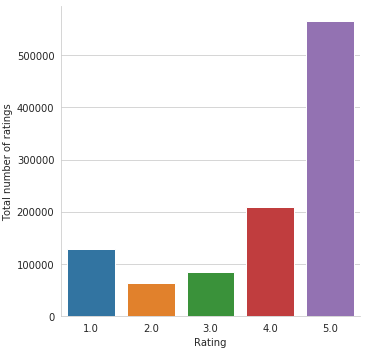

In [11]:
# Check the distribution of the rating
with sns.axes_style('whitegrid'):
    g = sns.factorplot("Rating", data=df, aspect=1.0,kind='count')
    g.set_ylabels("Total number of ratings")

#### Most of the people has given the rating of 5

### Finding out unique users and products


In [12]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.User_ID)))
print("Total No of products  :", len(np.unique(df.Product_ID)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


### Dropping the TimeStamp Column

In [13]:
#Dropping the Timestamp column

df.drop(['Timestamp'], axis=1,inplace=True)

### Analysis of the ratings

In [14]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = df.groupby(by='User_ID')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

User_ID
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()


count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [16]:
print('\n No of rated product having more than 50 per user reviews: {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product having more than 50 per user reviews: 38



# Popularity Based Recommendation

Popularity based recommendation system works on the trend. This model basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The drawback of the popularity based recommendation system is that the user based personalization is not available i.e. even though you know the behaviour of the user but you cannot recommend items accordingly.

### Taking subset of the dataset. Users who have rated alteast 50 products

In [17]:
#Getting the new dataframe which contains users who has given 50 or more ratings

final_df=df.groupby("Product_ID").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, 'No. of Ratings per product')

Text(0.5, 0, 'Products ->')

Text(0, 0.5, 'No of Users who rated the product')

[]

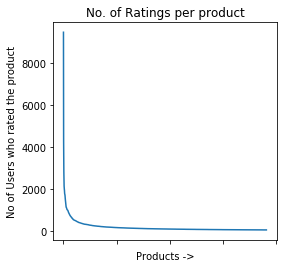

In [18]:
no_of_ratings_per_item = final_df.groupby(by='Product_ID')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(1))
ax = plt.gca()
plt.plot(no_of_ratings_per_item.values)
plt.title('No. of Ratings per product')
plt.xlabel('Products ->')
plt.ylabel('No of Users who rated the product')
ax.set_xticklabels([])

plt.show()

In [19]:
#Average rating of the product 

final_df.groupby('Product_ID')['Rating'].mean().head()

Product_ID
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [20]:
final_df.groupby('Product_ID')['Rating'].mean().sort_values(ascending=False).head()


Product_ID
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [21]:
#Total no of rating for product

final_df.groupby('Product_ID')['Rating'].count().sort_values(ascending=False).head()

Product_ID
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [22]:
ratings_mean_count = pd.DataFrame(final_df.groupby('Product_ID')['Rating'].mean())


In [23]:
ratings_mean_count['rating_counts'] = pd.DataFrame(final_df.groupby('Product_ID')['Rating'].count())


In [24]:
ratings_mean_count.head()


,Rating,rating_counts
Product_ID,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [25]:
ratings_mean_count['rating_counts'].max()

9487

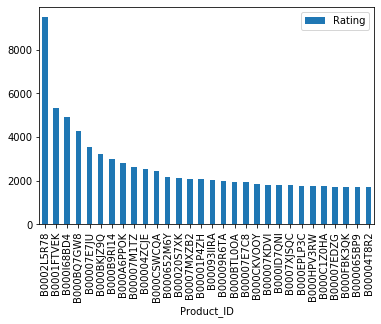

In [26]:
popular_products = pd.DataFrame(final_df.groupby('Product_ID')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Collaberative filtering model (Item-Item recommedation)

Collaborative filtering is commonly used for recommendation systems. These techniques aim to impute the missing entries of a user-item association matrix. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item. Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

In [49]:
from surprise import KNNWithMeans
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [28]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_df,reader)

In [29]:
#Splitting the dataset in 70/30 ratio
trainset, testset = train_test_split(data, test_size=0.3,random_state=20)

In [30]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [31]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [32]:
test_pred


[Prediction(uid='A1O9RSFJ8QUFJ6', iid='B000928KII', r_ui=5.0, est=4.049371841824672, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AV0G2QMZQEXZF', iid='B00004T8R2', r_ui=4.0, est=4.049371841824672, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3M6VSHU7QRSXO', iid='B00004Z5D1', r_ui=5.0, est=4.049371841824672, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A17R9HPXLAXB92', iid='B000EVSLRO', r_ui=5.0, est=4.135746606334842, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3SC1MD7RG0BX2', iid='B000068UY6', r_ui=5.0, est=4.782711038961039, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3UBX7VT0VR2U6', iid='B000I20BBI', r_ui=5.0, est=4.049371841824672, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A7F5Y3YA1QJRD', iid='B000092TT0', r_ui=4.0, est=4.049371841824672, d

In [33]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3426


1.3426088227642046

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [36]:
new_df1=final_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='User_ID', columns='Product_ID', fill_value=0)
ratings_matrix.head()

Product_ID,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
User_ID,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [37]:
ratings_matrix.shape

(9832, 76)

Transposing the matrix

In [38]:
X = ratings_matrix.T
X.head()

User_ID,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
Product_ID,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X.shape

(76, 9832)

Unique products in subset of data


In [40]:
X1 = X

In [41]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [42]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [43]:
X.index[50]


'B00000J434'

In [45]:
i = "B00000J434"
product_names = list(X.index)
product_ID = product_names.index('B00000J434')
product_ID

50

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [46]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Recommending top 5 highly correlated products in sequence



In [47]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:5]

['7214047977', '9966694544', '9983891212', 'B00000IGBF', 'B00000J1EJ']

Above are the top 5 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.


### Cross Validation

# Summary: 

There are different types of the recommendations systems :-

1. Popularity based systems :- This model works by recommeding items viewed and purchased by most people and are rated high.This is not a personalized recommendation.
2. Classification model based:- This model works by understanding the features of the user and applying the classification algorithm to decide whether the user is/ will be interested or not in the product.
3. Content based recommedations:- This is based on the information on the contents of the item rather than on the user opinions.The main idea is if the user likes an item then he or she will like the "other" similar item.
4. Collaberative Filtering:- It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types:
 a) User-User 
 b) Item -Item
 
5. Hybrid Approaches:- This system approach is to combine collaborative filtering, content-based filtering, and other approaches . 
6. Association rule mining :- Association rules capture the relationships between items based on their patterns of co-occurrence across transactions.(Apriori principle). Market Basket Analysis is a popular application of Association Rules.